# DNN Practical: Ag Detection by Muon Spectroscopy

In this notebook, we attempt to solve a real problem in physics using a fully connected DNN.

We have a set of spectra from Muon spectroscopy experiments, from which we would like to detect whether or not a certain element is present in a sample. In this notebook, we are going to train a neural network to detect the presence of Ag. Through this practice, we will encounter and overcome two pitfalls in deep learning, **class imbalance** and **overfitting**. We will also explore **early stoping** and saving checkpoints from the best performing model.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# need some certainty in data processing
np.random.seed(0)

Using TensorFlow v2.1.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/muon-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data/muon-data/'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset

### Read raw data

The raw data, which include the constituent elements and the Muon spectra of the samples, are stored in the pickle file `muon/Ag_muon_data.pkl`. We load this file into a `pandas` dataframe and take a quick look.

In [4]:
# read data
df = pd.read_pickle(data_path + 'ag-muon-data-tight.pkl')
#print dimensions
print('Number of samples in the dataset: %d' % len(df['Spectra']))
print('Length of spectra for each sample: %d' % len(df['Spectra'][0]))

# print the first few data
df.head(n=5)

Number of samples in the dataset: 138613
Length of spectra for each sample: 1000


,Elements,oh,c,Spectra
8877,"[Si, Fe, Sb, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 132.19327401887..."
88555,"[Sb, Fe, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.91719527298..."
111153,"[Si, Sb]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.04741040971..."
27279,"[Fe, Cu, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.84704457348..."
26419,"[Si, Fe]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.82180543319..."


In the above table, the `Elements` and the `Spectra` columns show respectively the elements and the spectra of the samples. There are 224,000 samples in the dataset, and each spectrum is a series of 300 positive reals. 

To get a feel for the complexity of picking out signals with Ag in multinary samples, we can plot some random spectra for three representative cases: 

* no Ag
* pure Ag
* Ag-Si binary

Note that we are plotting only the first half of each spectrum. Change `[0:150]` to `[:]` to show the full spectra.

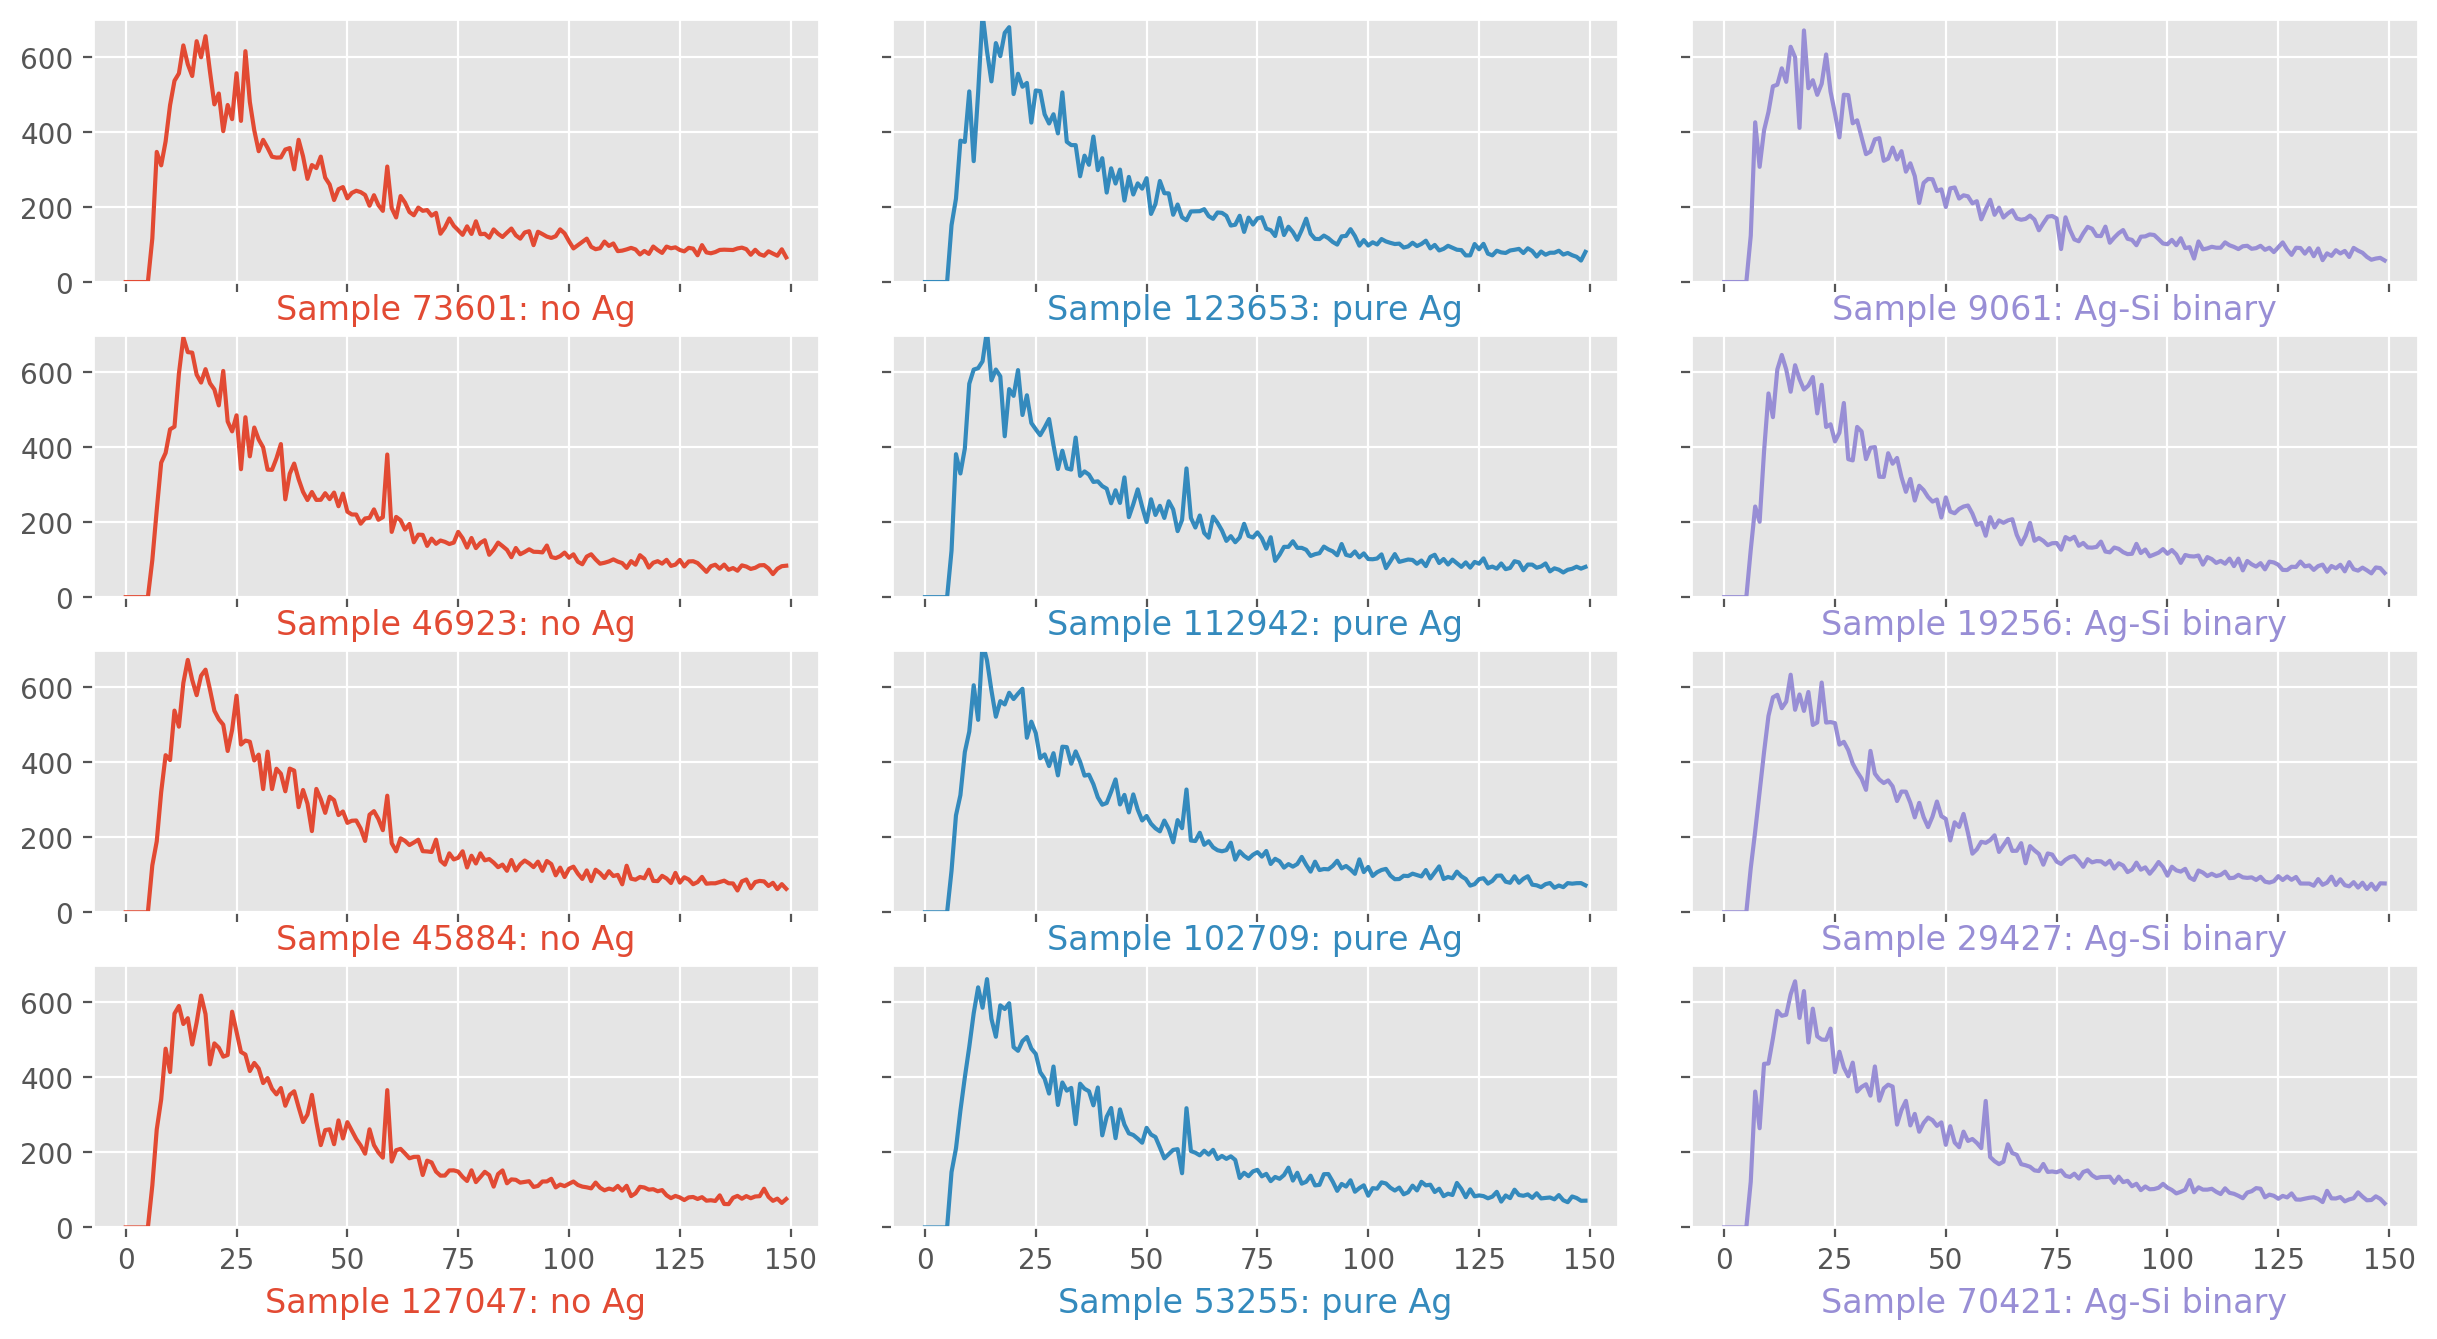

In [5]:
# conditions to select data
conditions = [
# no Ag
('no Ag', np.where(['Ag' not in elements for elements in df['Elements']])[0]),
# pure Ag
('pure Ag', np.where([['Ag'] == elements for elements in df['Elements']])[0]),
# Ag-Si
('Ag-Si binary', np.where([['Ag', 'Si'] == elements for elements in df['Elements']])[0])
]

# plot
ncond = len(conditions)
nplot = 4 # number of plots per condition
fig, axs = plt.subplots(nplot, ncond, dpi=200, figsize=(ncond * 5, nplot * 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.2)
for icond, cond in enumerate(conditions):
    for iplot, idata in enumerate(np.random.choice(cond[1], nplot)):
        axs[iplot, icond].plot(df['Spectra'][idata][0:150], c='C%d' % icond)
        axs[iplot, icond].set_xlabel('Sample %d: %s' % (idata, cond[0]), c='C%d' % icond)
        axs[iplot, icond].set_ylim(0, 700)

### Extract training data

The input data for our network will be the `Spectra` column, and we can use the `to_list()` method to convert it to a numpy array. A quick inspection over the spectra shows that the second half of each spectrum has mostly vanished and is thus uninformative; therefore, we will *only use the first half of each spectrum for training*. Such simple data preprocessing can help to reduce model scale and improve both accuracy and performance. 

The output data for our network will be a binary-valued one-hot vector: 0 for no Ag in the sample and 1 otherwise. One-hot encoding can be achieved by a simple for-loop.

In [7]:
###### input ######
# convert the 'Spectra' column to numpy
train_x = np.array(df['Spectra'].to_list())[:50000]
# only take the first half for training
train_x = train_x[:, 0:1000]

###### output ######
# one-hot encoding: whether Ag is in 'Elements'
train_y = np.array(['Ag' in elements for elements in df['Elements']]).astype(int)[:50000]

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))

Shape of input: (50000, 1000)
Shape of output: (50000,)


---

# Ag-detection by DNN

## 1. Try out a network


### Build and compile

Based on what we have learnt in [03_DNN_basics.ipynb](03_DNN_basics.ipynb), design a simple neural network with `Dense` layers to detect Ag in the spectra. In general, it is not a straightforward task to determine the number of hidden layers and the number of neurons in each layer, which usually involves some trial and error. In this case, our output size is 1, so we'd better add a small layer before it, such as one with size 8; then, between this hidden layer and the input layer (with size 150), we may add another hidden layer with size 64, approximately halfway between 8 and 150. 

Next, compile the model. We can keep using `adam` for the `optimizer` and `['accuracy']` for the `metrics`. For the `loss`, since we are fitting to a range between 0 and 1, we can choose `binary_crossentropy`.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```
    
</p>
</details>


In [7]:
# define the model
# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# print model summary
model.summary()

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                64064     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 67,073
Trainable params: 66,945
Non-trainable params: 128
__________________________________________________

### Train the model

Since we have not separated a subset of data for validation, we can pass `validation_split=0.2` to `model.fit()`, which then will use the *final* 20% of the dataset for validation. Let us do 20 epochs first.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(train_x, train_y, epochs=20, batch_size=64, 
                             validation_split=0.2)
```
    
</p>
</details>

In [8]:
# train the model
training_history = model.fit(train_x, train_y, epochs=10, batch_size=64, 
                             validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2519 - accuracy: 0.9212 - val_loss: 0.3503 - val_accuracy: 0.9267
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1153 - accuracy: 0.9599 - val_loss: 1.7606 - val_accuracy: 0.3064
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0565 - accuracy: 0.9806 - val_loss: 0.0538 - val_accuracy: 0.9828
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.7511 - val_accuracy: 0.7180
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0343 - accuracy: 0.9884 - val_loss: 0.1967 - val_accuracy: 0.9543
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0301 - accuracy: 0.9895 - val_loss: 5.5188 - val_accuracy: 0.0934
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.0569 - val_accuracy: 0.9838
Epoch 

### Plot training history

For convenience, we define a function to plot a training history:

In [9]:
# a function to plot training history
def plot_history(training_history):
    # plot accuracy
    plt.figure(dpi=100, figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(training_history.history[acc_str], label='Accuracy on training data')
    plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
    plt.legend()
    plt.title("Accuracy")

    # plot loss
    plt.subplot(1, 2, 2)
    plt.plot(training_history.history['loss'], label='Loss on training data')
    plt.plot(training_history.history['val_loss'], label='Loss on test data')
    plt.legend()
    plt.title("Loss")
    plt.show()

Now, plot the training history of the current model. They will look bizarre at this stage, as explained in the forthcoming section.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# plot training history
plot_history(training_history)
```
    
</p>
</details>

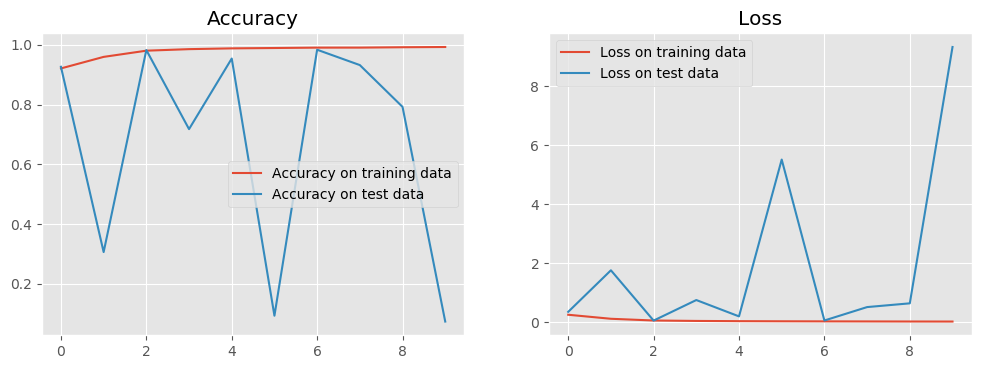

In [10]:
# plot training history
plot_history(training_history)

## 2. Class imbalance

In the above history plot, notice how the accuracy of the model quickly converges to a certain value and then stops improving completely. This value can be well above 50% (above 95% by the suggested answer), implying that the model is actually picking up something from the dataset. More strangely, the accuracy for the validation data can even be higher than that for the training data (always 100% by the suggested answer). These odd results indicate that something could be wrong within our dataset.

### Data distribution

Let us inspect the distribution of the data using `plt.hist(train_y)`, paying special attention to the validation part (the final 20%).

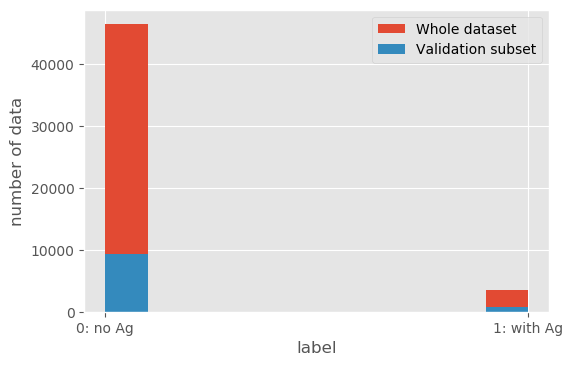

In [11]:
# plot distribution of data
plt.figure(dpi=100)
plt.hist(train_y, label='Whole dataset')
plt.hist(train_y[-len(train_y)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

The histograms show that our dataset is dominated by samples labelled 0 or "no Ag", which account for over 95% of the data. Thus, if the model simply learns to *guess* "no Ag" in every sample, it can achieve 95% accuracy (and 100% for the validation subset) without learning anything meaningful. This problem is known as **class imbalance**.

To avoid this, we must balance the classes. There are a number of strategies we can take:

* Upsample the minority class;
* Downsample the majority class;
* Change the performance metric.

The best available option for our problem is to downsample the majority class, which can be easily achieved with `numpy`:

In [8]:
# find original indices of 0 ('no Ag') and 1 ('with Ag')
id_no_Ag = np.where(train_y == 0)[0]
id_with_Ag = np.where(train_y == 1)[0]

# downsample 'no Ag' to the number of 'with Ag' by np.random.choice
id_no_Ag_downsample = np.random.choice(id_no_Ag, len(id_with_Ag))

# concatenate 'with Ag' and downsampled 'no Ag'
id_downsample = np.concatenate((id_with_Ag, id_no_Ag_downsample))

# shuffle the indices because they are ordered after concatenation
np.random.shuffle(id_downsample)

# finally get the balanced data
train_x_balanced = train_x[id_downsample]
train_y_balanced = train_y[id_downsample]

Re-exam the histograms of the balanced dataset after downsampling the majority:

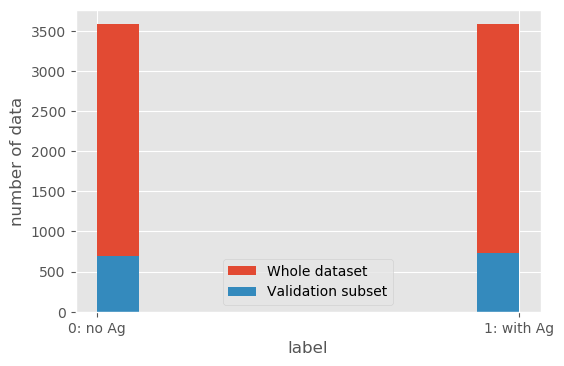

In [9]:
# plot distribution of downsampled data
plt.figure(dpi=100)
plt.hist(train_y_balanced, label='Whole dataset')
plt.hist(train_y_balanced[-len(train_y_balanced)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

### Re-train the model

Now we can re-train the model with the balanced dataset. Simply change `train_x` and `train_y` to `train_x_balanced` and `train_y_balanced` in `model.fit()` and repeat all the steps in [1. Try out a network](#1.-Try-out-a-network). Note that, to avoid the influence of the initial model state (weights and biases) left by the previous training (such as the one trained with the imbalanced dataset), we have to first re-define and re-compile the model before calling `model.fit()`. A larger `epochs` can be used because we now have much fewer data.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
import time
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)


# re-compile the model
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.clock() - tic))
```
    
</p>
</details>

In [ ]:
import time
# set a random seed
tf.random.set_seed(0)

# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)


# re-compile the model
model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.clock() - tic))

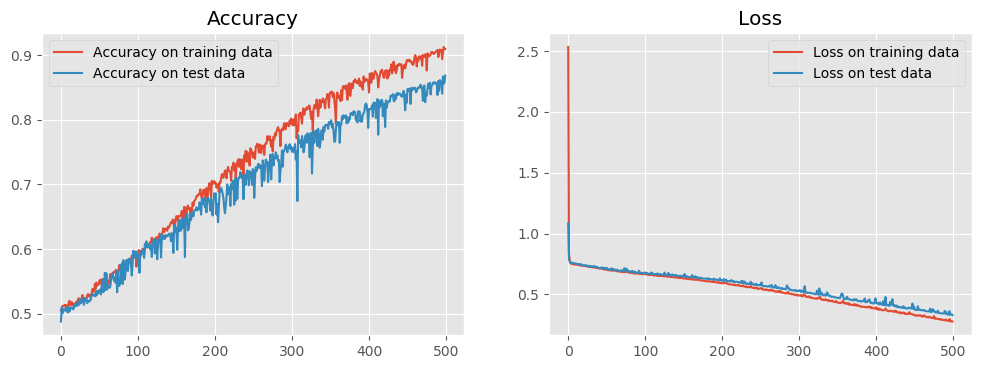

In [10]:
# plot training history
plot_history(training_history_balanced)

### Overfitting

The history shows that our model is sightly overfitting, with the accuracy for the training data converging to 0.99 and that for the test data to 0.96. This can be alleviated by a dropout layer with a rate of 0.1 after the first hidden layer: try adding `model.add(Dropout(0.001))` after `model.add(Dense(64, ...))`. We also lower the learning rate to `5e-5` - failure to do this in this instance can lead to the model becoming trapped in a local minimum.

**Note** This dropout rate is actually rather small, but is best for this particular instance. Generally a dropout rate of between `0.1 - 0.5` is applied, but if you notice that the model fails to learn with a higher rate, then lower rates can be tried. If you like you can see the effecet of a rate of `0.1` in this model. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# set a random seed
tf.random.set_seed(0)


# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dropout(0.001))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.clock() - tic))
    ```
</p>
</details>

In [21]:
# set a random seed
tf.random.set_seed(0)


# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# re-train the model
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2)
print('run time: {:5.3f} s'.format(time.clock() - tic))



/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Train on 5736 samples, validate on 1434 samples
Epoch 1/500
5736/5736 [==============================] - 1s 148us/sample - loss: 1.3379 - accuracy: 0.5037 - val_loss: 0.7555 - val_accuracy: 0.4847
Epoch 2/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.8657 - accuracy: 0.4991 - val_loss: 0.7165 - val_accuracy: 0.5160
Epoch 3/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.7728 - accuracy: 0.4934 - val_loss: 0.6952 - val_accuracy: 0.5307
Epoch 4/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.7524 - accuracy: 0.5033 - val_loss: 0.6967 - val_accuracy: 0.5384
Epoch 5/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.7480 - accuracy: 0.5122 - val_loss: 0.6937 - val_accuracy: 0.5314
Epoch 6/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.7343 - accuracy: 0.5047 - val_loss: 0.7033 - val_accuracy: 0.5091
Epoch 7/500
5736/5736 [==============================] - 0s 21u

Epoch 56/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.6549 - accuracy: 0.5905 - val_loss: 0.6371 - val_accuracy: 0.6764
Epoch 57/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6336 - accuracy: 0.6464 - val_loss: 0.6264 - val_accuracy: 0.6409
Epoch 58/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.6229 - accuracy: 0.6503 - val_loss: 0.6190 - val_accuracy: 0.6527
Epoch 59/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.6436 - accuracy: 0.6247 - val_loss: 0.6224 - val_accuracy: 0.6660
Epoch 60/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6096 - accuracy: 0.6641 - val_loss: 0.6047 - val_accuracy: 0.6834
Epoch 61/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.6048 - accuracy: 0.6578 - val_loss: 0.6265 - val_accuracy: 0.6220
Epoch 62/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6662 - accuracy: 0.5966

Epoch 111/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3093 - accuracy: 0.8649 - val_loss: 0.2996 - val_accuracy: 0.8759
Epoch 112/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3532 - accuracy: 0.8344 - val_loss: 0.3284 - val_accuracy: 0.8543
Epoch 113/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3211 - accuracy: 0.8581 - val_loss: 0.3032 - val_accuracy: 0.8654
Epoch 114/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.3018 - accuracy: 0.8685 - val_loss: 0.3299 - val_accuracy: 0.8577
Epoch 115/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.3099 - accuracy: 0.8623 - val_loss: 0.2855 - val_accuracy: 0.8794
Epoch 116/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.3101 - accuracy: 0.8694 - val_loss: 0.6035 - val_accuracy: 0.6994
Epoch 117/500
5736/5736 [==============================] - 0s 23us/sample - loss: 0.3404 - accuracy:

Epoch 220/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.1322 - accuracy: 0.9444 - val_loss: 0.1341 - val_accuracy: 0.9449
Epoch 221/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1552 - accuracy: 0.9338 - val_loss: 0.2941 - val_accuracy: 0.8801
Epoch 222/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.2000 - accuracy: 0.9067 - val_loss: 0.1350 - val_accuracy: 0.9442
Epoch 223/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1293 - accuracy: 0.9454 - val_loss: 0.1297 - val_accuracy: 0.9407
Epoch 224/500
5736/5736 [==============================] - 0s 19us/sample - loss: 0.1288 - accuracy: 0.9461 - val_loss: 0.1289 - val_accuracy: 0.9407
Epoch 225/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1336 - accuracy: 0.9435 - val_loss: 0.1800 - val_accuracy: 0.9289
Epoch 226/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3044 - accuracy:

Epoch 329/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.0946 - accuracy: 0.9594 - val_loss: 0.1055 - val_accuracy: 0.9609
Epoch 330/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1126 - accuracy: 0.9517 - val_loss: 0.1565 - val_accuracy: 0.9400
Epoch 331/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1179 - accuracy: 0.9484 - val_loss: 0.1633 - val_accuracy: 0.9358
Epoch 332/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1157 - accuracy: 0.9510 - val_loss: 0.3805 - val_accuracy: 0.8696
Epoch 333/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1769 - accuracy: 0.9215 - val_loss: 0.1171 - val_accuracy: 0.9554
Epoch 334/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.0951 - accuracy: 0.9622 - val_loss: 0.1677 - val_accuracy: 0.9358
Epoch 335/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.0967 - accuracy:

Epoch 438/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.0972 - accuracy: 0.9623 - val_loss: 0.1744 - val_accuracy: 0.9310
Epoch 439/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.2103 - accuracy: 0.9081 - val_loss: 0.3491 - val_accuracy: 0.8752
Epoch 440/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.2809 - accuracy: 0.8924 - val_loss: 0.0881 - val_accuracy: 0.9658
Epoch 441/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.1111 - accuracy: 0.9531 - val_loss: 0.1196 - val_accuracy: 0.9547
Epoch 442/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.0786 - accuracy: 0.9697 - val_loss: 0.0863 - val_accuracy: 0.9672
Epoch 443/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.0858 - accuracy: 0.9646 - val_loss: 0.1302 - val_accuracy: 0.9526
Epoch 444/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.0928 - accuracy:

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


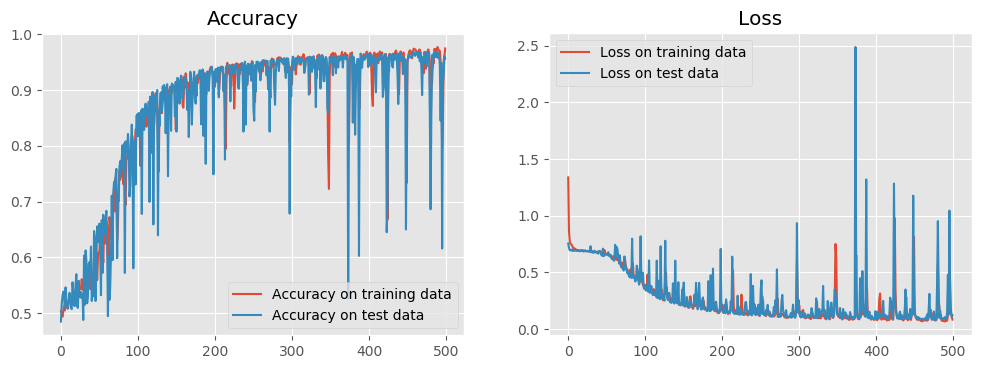

In [22]:
# plot training history
plot_history(training_history_balanced)

The droput has brought the training and validation losses closer to one another. However we also see that there are large oscillations in the validation performance. This is realted to the rather small training and validation set sizes. How can we make sure that we recover the model with the best performance on validation?

We can use a **callback** to tell the algorithm to save the model every time there is a new best validation loss. We can then also tell the training algorithm to cease if the validation loss has not improved for _n_ steps; below we set up a callback to monitor the `val_accuracy` and to stop if this has not improved for 50 steps, then restore the weights of the best model. 

```
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
```

The callbacks are then specified as a list of all callbacks you defined and passed to the `fit` function _via_ the keyword `callbacks`.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python

# set a random seed
tf.random.set_seed(0)


# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dropout(0.001))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
    
# re-train the model
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.clock() - tic))


# plot training history
plot_history(training_history_balanced)
```
    
</p>
</details>

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Train on 5736 samples, validate on 1434 samples
Epoch 1/500
5736/5736 [==============================] - 0s 87us/sample - loss: 1.3379 - accuracy: 0.5037 - val_loss: 0.7555 - val_accuracy: 0.4847
Epoch 2/500
5736/5736 [==============================] - 0s 19us/sample - loss: 0.8657 - accuracy: 0.4991 - val_loss: 0.7165 - val_accuracy: 0.5160
Epoch 3/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.7728 - accuracy: 0.4934 - val_loss: 0.6952 - val_accuracy: 0.5307
Epoch 4/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.7524 - accuracy: 0.5033 - val_loss: 0.6967 - val_accuracy: 0.5384
Epoch 5/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.7480 - accuracy: 0.5122 - val_loss: 0.6937 - val_accuracy: 0.5314
Epoch 6/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.7343 - accuracy: 0.5047 - val_loss: 0.7033 - val_accuracy: 0.5091
Epoch 7/500
5736/5736 [==============================] - 0s 21us

Epoch 56/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.6633 - accuracy: 0.5908 - val_loss: 0.6534 - val_accuracy: 0.6374
Epoch 57/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6583 - accuracy: 0.5962 - val_loss: 0.6525 - val_accuracy: 0.6297
Epoch 58/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6496 - accuracy: 0.6124 - val_loss: 0.6774 - val_accuracy: 0.5446
Epoch 59/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.6682 - accuracy: 0.5741 - val_loss: 0.6443 - val_accuracy: 0.6381
Epoch 60/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.6405 - accuracy: 0.6402 - val_loss: 0.6568 - val_accuracy: 0.5962
Epoch 61/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.6482 - accuracy: 0.6100 - val_loss: 0.6953 - val_accuracy: 0.5335
Epoch 62/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.6340 - accuracy: 0.6348

Epoch 111/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3332 - accuracy: 0.8436 - val_loss: 0.3239 - val_accuracy: 0.8577
Epoch 112/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.4042 - accuracy: 0.7978 - val_loss: 0.3313 - val_accuracy: 0.8550
Epoch 113/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.3401 - accuracy: 0.8377 - val_loss: 0.3939 - val_accuracy: 0.8068
Epoch 114/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3345 - accuracy: 0.8421 - val_loss: 0.3372 - val_accuracy: 0.8550
Epoch 115/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3303 - accuracy: 0.8407 - val_loss: 0.3038 - val_accuracy: 0.8787
Epoch 116/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3286 - accuracy: 0.8492 - val_loss: 0.4246 - val_accuracy: 0.7873
Epoch 117/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.3685 - accuracy:

Epoch 220/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.1598 - accuracy: 0.9243 - val_loss: 0.1545 - val_accuracy: 0.9372
Epoch 221/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1656 - accuracy: 0.9210 - val_loss: 0.2496 - val_accuracy: 0.8989
Epoch 222/500
5736/5736 [==============================] - 0s 22us/sample - loss: 0.2205 - accuracy: 0.8959 - val_loss: 0.1722 - val_accuracy: 0.9289
Epoch 223/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1498 - accuracy: 0.9331 - val_loss: 0.1571 - val_accuracy: 0.9393
Epoch 224/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1534 - accuracy: 0.9320 - val_loss: 0.1725 - val_accuracy: 0.9303
Epoch 225/500
5736/5736 [==============================] - 0s 21us/sample - loss: 0.1502 - accuracy: 0.9278 - val_loss: 0.2320 - val_accuracy: 0.9003
Epoch 226/500
5736/5736 [==============================] - 0s 20us/sample - loss: 0.2496 - accuracy:

/home/mts87985/src/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


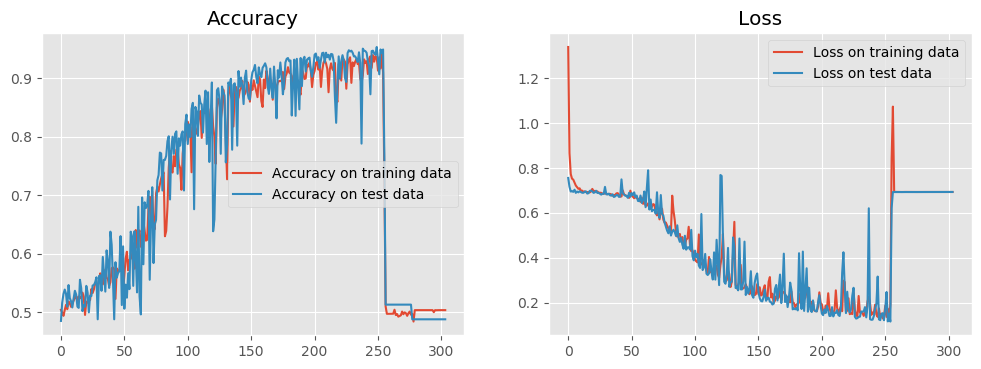

In [20]:
# set a random seed
tf.random.set_seed(0)


# re-define the model
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
ad = Adam(learning_rate=5e-5, beta_1=0.9, beta_2=0.999, amsgrad=False)

# re-compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

# re-train the model
tic = time.clock()
# re-train the model
training_history_balanced = model.fit(train_x_balanced, train_y_balanced, 
                                      epochs=500, batch_size=256, validation_split=0.2,
                                      callbacks=[callback])
print('run time: {:5.3f} s'.format(time.clock() - tic))


# plot training history
plot_history(training_history_balanced)

---

## Exercises

Build a DNN to detect the presence of all the elements. To do this, you may go through the following steps:

1. Find all the elements appearing in the dataset; the answer will be `['Zn', 'Sb', 'Si', 'Fe', 'Ag', 'Cu', 'Bi']`.
2. Balance the dataset: if one of the elements appears much less times than the others, it is better to ignore it. Doing everything correctly, you will find the number of samples containing each element as shown in the following table. Therefore, we may ignore Ag in this network.


|  Element | # Samples |
|---|---|
|Zn| 91935|  
|Sb| 91880|  
|Si| 91672| 
|Fe| 91446|
|Ag| 8617|
|Cu| 92133|
|Bi| 91796|
    
3. Do one-hot encoding for the element list `['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']`; if a sample contains Fe and Sb, e.g., the one-hot vector for this sample will be `[0, 1, 0, 1, 0, 0]`.
4. Build and train a DNN (with an input size of 150 and an output size of 6) to detect the presence of the six elements.

Do not feel disappointed if the accuracy of the DNN turns out low, as some of the elements are physically indistinguishable from the given spectra. Nevertheless, our DNN can still mine useful information from the dataset. By comparing the predictions and the ground truth, you may notice that **only one element** is dominating the training, that is, the network can correctly predict the presence of this element while the predictions for the other elements are basically random. This indicates that the given set of spectra is characterised by this element (not considering Ag). Figure out what the element is. 
